# Engesgaard and Kipp 1992

The case described by example 1 was originally presented by Engesgaard and Kipp (1992) for a model verification of their MST1D code against the CHEMTRNS model by Noorishad et al. (1987). It involves a one-dimensional model domain in which an aqueous water composition that is in equilibrium with two minerals, calcite and dolomite, is successively replaced, i.e., flushed by water of a different chemical composition, leading to multiple precipitation-dissolution fronts. Dolomite is not present initially but is formed temporally.

In [1]:
from pathlib import Path
import os
from modflowapi.extensions import ApiSimulation
from modflowapi import Callbacks
# from workflow import *
from datetime import datetime
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#add mf6rtm path to the system
import flopy
from mf6rtm import utils
from mf6rtm import mf6rtm
prefix = 'ex1'
DT_FMT = "%Y-%m-%d %H:%M:%S"

dataws = os.path.join("data")
databasews = os.path.join("database")

## Flow and Transport Setup

In [2]:
### Model params and setup

# General
length_units = "meters"
time_units = "days"

nper = 1  # Number of periods
nlay = 1  # Number of layers
Lx = 0.5 #m
ncol = 50 # Number of columns
nrow = 1  # Number of rows
delr = Lx/ncol #10.0  # Column width ($m$)
delc = 1.0  # Row width ($m$)
top = 0.  # Top of the model ($m$)
botm = -1.0  # Layer bottom elevations ($m$)
prsity = 0.32  # Porosity
k11 = 1.0  # Horizontal hydraulic conductivity ($m/d$)
k33 = k11  # Vertical hydraulic conductivity ($m/d$)

tstep = 0.01  # Time step ($days$)
perlen = 0.24  # Simulation time ($days$)
nstp = perlen/tstep #100.0
dt0 = perlen / nstp

chdspd = [[(0, 0, ncol - 1), 1.]]  # Constant head boundary $m$
strt = np.zeros((nlay, nrow, ncol), dtype=float)
strt[0, 0, :] = 1  # Starting head ($m$)

tdis_rc = []
tdis_rc.append((perlen, nstp, 1.0))

icelltype = 1  # Cell conversion type
ibound = np.ones((nlay, nrow, ncol), dtype=int)
ibound[0, 0, -1] = -1

q=0.259 #m3/d

wel_spd = [[(0,0,0), q]]

#transport
dispersivity = 0.0067 # Longitudinal dispersivity ($m$)

# Set solver parameter values (and related)
nouter, ninner = 100, 300
hclose, rclose, relax = 1e-6, 1e-6, 1.0
ttsmult = 1.0
dceps = 1.0e-5  # HMOC parameters in case they are invoked
nplane = 1  # HMOC
npl = 0  # HMOC
nph = 4  # HMOC
npmin = 0  # HMOC
npmax = 8  # HMOC
nlsink = nplane  # HMOC
npsink = nph  # HMOC

## Initialize Chemistry in Domain

In [3]:

files = [f for f in os.listdir(dataws) if f.startswith(prefix)]

solutionsdf = pd.read_csv(os.path.join(dataws,f"{prefix}_solutions.csv"), comment = '#',  index_col = 0)

# solutions = utils.solution_csv_to_dict(os.path.join(dataws,f"{prefix}_solutions.csv"))
solutions = utils.solution_df_to_dict(solutionsdf)

#get postfix file
solutionsdf

,sol_bck,sol_in
comp,,
pH,9.910000,7.000
pe,4.000000,4.000
C(+4),0.000123,0.000
Ca,0.000123,0.000
Cl,0.000000,0.002
Mg,0.000000,0.001


In [4]:
# get equilibrium phases file
equilibrium_phases = utils.equilibrium_phases_csv_to_dict(os.path.join(dataws, f'{prefix}_equilibrium_phases.csv'))
equilibrium_phases

{1: {'Calcite': [0.0, 0.0001220625], 'Dolomite': [0.0, 0.0]}}

In [5]:
#assign solutions to grid
# sol_ic = np.ones(ncol)
sol_ic = 1

#add solutions to clss
solution = mf6rtm.Solutions(solutions)
solution.set_ic(sol_ic)

#create equilibrium phases class
equilibrium_phases = mf6rtm.EquilibriumPhases(equilibrium_phases)
equilibrium_phases.set_ic(1)

#create model class
model = mf6rtm.Mup3d(prefix,solution, nlay, nrow, ncol)

#set model workspace
model.set_wd(os.path.join(f'{prefix}', f'mf6rtm'))

#set database
database = os.path.join(databasews, f'pht3d_datab.dat')
model.set_database(database)

#include equilibrium phases in model class
model.set_equilibrium_phases(equilibrium_phases)

postfix = os.path.join(dataws, f'{prefix}_postfix.phqr')
model.set_postfix(postfix)

In [6]:
#initialize model
model.initialize()

Using temperatue of 25.0 for all cells
Phreeqc initialized


In [7]:
wellchem = mf6rtm.ChemStress('wel')

sol_spd = [2]

wellchem.set_spd(sol_spd)

In [8]:
model.set_chem_stress(wellchem)


Initializing ChemStress
ChemStress wel initialized


## Build mf6 model

In [9]:
def build_model(model):
    ##################### GWF model #####################

    gwfname = 'gwf'
    sim_ws = model.wd
    sim = flopy.mf6.MFSimulation(sim_name=model.name, sim_ws=sim_ws, exe_name='mf6')

    # Instantiating MODFLOW 6 time discretization
    flopy.mf6.ModflowTdis(sim, nper=nper, perioddata=tdis_rc, time_units=time_units)

    # Instantiating MODFLOW 6 groundwater flow model
    gwf = flopy.mf6.ModflowGwf(
        sim,
        modelname=gwfname,
        save_flows=True,
        model_nam_file=f"{gwfname}.nam",
    )

    # Instantiating MODFLOW 6 solver for flow model
    imsgwf = flopy.mf6.ModflowIms(
        sim,
        print_option="SUMMARY",
        outer_dvclose=hclose,
        outer_maximum=nouter,
        under_relaxation="NONE",
        inner_maximum=ninner,
        inner_dvclose=hclose,
        rcloserecord=rclose,
        linear_acceleration="CG",
        scaling_method="NONE",
        reordering_method="NONE",
        relaxation_factor=relax,
        filename=f"{gwfname}.ims",
    )
    sim.register_ims_package(imsgwf, [gwf.name])

    # Instantiating MODFLOW 6 discretization package
    dis = flopy.mf6.ModflowGwfdis(
        gwf,
        length_units=length_units,
        nlay=nlay,
        nrow=nrow,
        ncol=ncol,
        delr=delr,
        delc=delc,
        top=top,
        botm=botm,
        idomain=np.ones((nlay, nrow, ncol), dtype=int),
        filename=f"{gwfname}.dis",
    )
    dis.set_all_data_external()

    # Instantiating MODFLOW 6 node-property flow package
    npf = flopy.mf6.ModflowGwfnpf(
        gwf,
        save_flows=True,
        save_saturation = True,
        icelltype=icelltype,
        k=k11,
        k33=k33,
        save_specific_discharge=True,
        filename=f"{gwfname}.npf",
    )
    npf.set_all_data_external()
    # Instantiating MODFLOW 6 initial conditions package for flow model
    flopy.mf6.ModflowGwfic(gwf, strt=strt, filename=f"{gwfname}.ic")

    # Instantiating MODFLOW 6 constant head package
    chd = flopy.mf6.ModflowGwfchd(
        gwf,
        maxbound=len(chdspd),
        stress_period_data=chdspd,
        save_flows=False,
        pname="CHD",
        filename=f"{gwfname}.chd",
    )
    chd.set_all_data_external()

    # if init_comp == None:
    #     auxiliary = 'tracer'
    # else:
    #     auxiliary = [c for c in init_comp]

    # if wel_rec == None:
    #     cin = 1.0e-3
    #     cin = concentration_l_to_m3(cin)
    #     wel_rec = spd = [[(0,0,0), 0.259, cin]]
    for i in range(len(wel_spd)):
        wel_spd[i].extend(model.wel.data[i])
    print(wel_spd)

    wel = flopy.mf6.ModflowGwfwel(
            gwf,
            stress_period_data=wel_spd,
            save_flows = True,
            auxiliary = model.components,
            pname = 'wel',
            filename=f"{gwfname}.wel"
        )
    wel.set_all_data_external()

    # Instantiating MODFLOW 6 output control package for flow model
    oc_gwf = flopy.mf6.ModflowGwfoc(
        gwf,
        head_filerecord=f"{gwfname}.hds",
        budget_filerecord=f"{gwfname}.cbb",
        headprintrecord=[("COLUMNS", 10, "WIDTH", 15, "DIGITS", 6, "GENERAL")],
        saverecord=[("HEAD", "ALL"), ("BUDGET", "ALL")],
        printrecord=[("HEAD", "LAST"), ("BUDGET", "LAST")],
    )
    
    #####################           GWT model          #####################
    for c in model.components:
        print(f'Setting model for component: {c}')
        gwtname = c
        
        # Instantiating MODFLOW 6 groundwater transport package
        gwt = flopy.mf6.MFModel(
            sim,
            model_type="gwt6",
            modelname=gwtname,
            model_nam_file=f"{gwtname}.nam"
        )

        # create iterative model solution and register the gwt model with it
        print('--- Building IMS package ---')
        imsgwt = flopy.mf6.ModflowIms(
            sim,
            print_option="SUMMARY",
            outer_dvclose=hclose,
            outer_maximum=nouter,
            under_relaxation="NONE",
            inner_maximum=ninner,
            inner_dvclose=hclose,
            rcloserecord=rclose,
            linear_acceleration="BICGSTAB",
            scaling_method="NONE",
            reordering_method="NONE",
            relaxation_factor=relax,
            filename=f"{gwtname}.ims",
        )
        sim.register_ims_package(imsgwt, [gwt.name])

        print('--- Building DIS package ---')
        dis = gwf.dis

        # create grid object
        dis = flopy.mf6.ModflowGwtdis(
            gwt,
            length_units=length_units,
            nlay=nlay,
            nrow=nrow,
            ncol=ncol,
            delr=delr,
            delc=delc,
            top=top,
            botm=botm,
            idomain=np.ones((nlay, nrow, ncol), dtype=int),
            filename=f"{gwtname}.dis",
        )
        dis.set_all_data_external()

         
        ic = flopy.mf6.ModflowGwtic(gwt, strt=model.sconc[c], filename=f"{gwtname}.ic")
        ic.set_all_data_external()

        # Instantiating MODFLOW 6 transport source-sink mixing package
        sourcerecarray = ['wel', 'aux', f'{c}']
        ssm = flopy.mf6.ModflowGwtssm(
            gwt, 
            sources=sourcerecarray, 

            filename=f"{gwtname}.ssm"
        )
        ssm.set_all_data_external()
        # Instantiating MODFLOW 6 transport adv package
        print('--- Building ADV package ---')
        adv = flopy.mf6.ModflowGwtadv(
            gwt,
            scheme="tvd",
        )

        # Instantiating MODFLOW 6 transport dispersion package
        alpha_l = np.ones(shape=(nlay, nrow, ncol))*dispersivity  # Longitudinal dispersivity ($m$)
        alpha_th = np.ones(shape=(nlay, nrow, ncol))*1  # Transverse horizontal dispersivity ($m$)
        alpha_tv = np.ones(shape=(nlay, nrow, ncol))*1  # Transverse vertical dispersivity ($m$)

        print('--- Building DSP package ---')
        dsp = flopy.mf6.ModflowGwtdsp(
            gwt,
            xt3d_off=True,
            alh=alpha_l,
            ath1=alpha_th,
            atv = alpha_tv,
            # diffc = diffc,
            filename=f"{gwtname}.dsp",
        )
        dsp.set_all_data_external()

        # Instantiating MODFLOW 6 transport mass storage package (formerly "reaction" package in MT3DMS)
        print('--- Building MST package ---')

        first_order_decay = None


        # print('--- Building SRC package ---')
        # src_spd = src_array(q, init_comp, c)
        # src = flopy.mf6.ModflowGwtsrc(
        #     gwt,
        #     stress_period_data = src_spd,
        #     save_flows = True,
        #     filename=f"{gwtname}.src"
        # )
        # src.set_all_data_external()

        mst = flopy.mf6.ModflowGwtmst(
            gwt,
            porosity=prsity,
            first_order_decay=first_order_decay,
            filename=f"{gwtname}.mst",
        )
        mst.set_all_data_external()

        print('--- Building OC package ---')

        # Instantiating MODFLOW 6 transport output control package
        oc_gwt = flopy.mf6.ModflowGwtoc(
            gwt,
            budget_filerecord=f"{gwtname}.cbb",
            concentration_filerecord=f"{gwtname}.ucn",
            concentrationprintrecord=[("COLUMNS", 10, "WIDTH", 15, "DIGITS", 10, "GENERAL")
                                        ],
            saverecord=[("CONCENTRATION", "ALL"), 
                        # ("BUDGET", "ALL")
                        ],
            printrecord=[("CONCENTRATION", "LAST"), 
                            # ("BUDGET", "ALL")
                            ],
        )

        # Instantiating MODFLOW 6 flow-transport exchange mechanism
        flopy.mf6.ModflowGwfgwt(
            sim,
            exgtype="GWF6-GWT6",
            exgmnamea=gwfname,
            exgmnameb=gwtname,
            filename=f"{gwtname}.gwfgwt",
        )

    sim.write_simulation()
    utils.prep_bins(sim_ws, src_path=os.path.join('..','bin'))
    
    return sim

In [10]:
sim = build_model(model)

[[(0, 0, 0), 0.259, 110684.17118025024, 55342.08560564267, -3.1035099315122177e-05, 0.0, 0.0, 1.994086023627226, 0.9970430118137076]]
Setting model for component: H
--- Building IMS package ---
--- Building DIS package ---
--- Building ADV package ---
--- Building DSP package ---
--- Building MST package ---
--- Building OC package ---
Setting model for component: O
--- Building IMS package ---
--- Building DIS package ---
--- Building ADV package ---
--- Building DSP package ---
--- Building MST package ---
--- Building OC package ---


Setting model for component: Charge
--- Building IMS package ---
--- Building DIS package ---


--- Building ADV package ---
--- Building DSP package ---
--- Building MST package ---
--- Building OC package ---
Setting model for component: C
--- Building IMS package ---
--- Building DIS package ---
--- Building ADV package ---
--- Building DSP package ---
--- Building MST package ---
--- Building OC package ---
Setting model for component: Ca
--- Building IMS package ---
--- Building DIS package ---
--- Building ADV package ---
--- Building DSP package ---
--- Building MST package ---
--- Building OC package ---


Setting model for component: Cl
--- Building IMS package ---
--- Building DIS package ---
--- Building ADV package ---
--- Building DSP package ---
--- Building MST package ---
--- Building OC package ---
Setting model for component: Mg
--- Building IMS package ---
--- Building DIS package ---
--- Building ADV package ---
--- Building DSP package ---
--- Building MST package ---
--- Building OC package ---
writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims_-1...
  writing solution package ims_0...
  writing solution package ims_1...
  writing solution package ims_2...
  writing solution package ims_3...
  writing solution package ims_4...
  writing solution package ims_5...
  writing solution package ims_6...
  writing package H.gwfgwt...
  writing package O.gwfgwt...
  writing package Charge.gwfgwt...
  writing package C.gwfgwt...
  writing package Ca.gwfgwt...
  writing package Cl.gwfgwt...
  writing package Mg.

    writing package oc...
  writing model Charge...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package ssm...
    writing package adv...
    writing package dsp...
    writing package mst...
    writing package oc...
  writing model C...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package ssm...
    writing package adv...
    writing package dsp...
    writing package mst...
    writing package oc...
  writing model Ca...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package ssm...
    writing package adv...
    writing package dsp...
    writing package mst...
    writing package oc...
  writing model Cl...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package ssm...
    writing package adv...
    writing package dsp...
    writing package mst...
    writing package oc...
  writing m

In [11]:
model.run_mup3d(sim)


-----------------------------  WELCOME TO  MUP3D -----------------------------

Transporting the following components: Flow, H, O, Charge, C, Ca, Cl, Mg


Starting transport solution at 2024-08-06 12:56:04

Solving solution 1 - Solving Flow
Transport stress period: 1 --- time step: 1 --- converged with 1 iters --- took 0.00015005 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 1 --- time step: 1 --- converged with 7 iters --- took 0.00020002 mins

Solution 2 finalized

Solving solution 3 - Solving O
Transport stress period: 1 --- time step: 1 --- converged with 13 iters --- took 0.00023342 mins

Solution 3 finalized

Solving solution 4 - Solving Charge
Transport stress period: 1 --- time step: 1 --- converged with 15 iters --- took 0.00026675 mins

Solution 4 finalized

Solving solution 5 - Solving C
Transport stress period: 1 --- time step: 1 --- converged with 21 iters --- took 0.00031677 mins

Solution 5 finalized

Solving solution 6 - Solving Ca
Transport stress period: 1 --- time step: 1 --- converged with 27 iters --- took 0.00036675 mins

Solution 6 finalized

Solving solution 7 - Solving Cl
Tra


Solving solution 2 - Solving H
Transport stress period: 1 --- time step: 5 --- converged with 5 iters --- took 0.00013335 mins

Solution 2 finalized

Solving solution 3 - Solving O
Transport stress period: 1 --- time step: 5 --- converged with 11 iters --- took 0.00018342 mins

Solution 3 finalized

Solving solution 4 - Solving Charge
Transport stress period: 1 --- time step: 5 --- converged with 12 iters --- took 0.00021675 mins

Solution 4 finalized

Solving solution 5 - Solving C
Transport stress period: 1 --- time step: 5 --- converged with 17 iters --- took 0.00025008 mins

Solution 5 finalized

Solving solution 6 - Solving Ca
Transport stress period: 1 --- time step: 5 --- converged with 23 iters --- took 0.00030008 mins

Solution 6 finalized

Solving solution 7 - Solving Cl
Transport stress period: 1 --- time step: 5 --- converged with 29 iters --- took 0.00035008 mins

Solution 7 finalized

Solving solution 8 - Solving Mg
Transport stress period: 1 --- time step: 5 --- converg


Getting concentration arrays --- time step: 9 --- elapsed time: 0.08

Transferring concentrations to mf6 for component: H

Transferring concentrations to mf6 for component: O

Transferring concentrations to mf6 for component: Charge

Transferring concentrations to mf6 for component: C

Transferring concentrations to mf6 for component: Ca

Transferring concentrations to mf6 for component: Cl

Transferring concentrations to mf6 for component: Mg

Solving solution 1 - Solving Flow
Transport stress period: 1 --- time step: 10 --- converged with 0 iters --- took 6.9117E-05 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 1 --- time step: 10 --- converged with 4 iters --- took 0.00010243 mins

Solution 2 finalized

Solving solution 3 - Solving O
Transport stress period: 1 --- time step: 10 --- converged with 10 iters --- took 0.00015243 mins

Solution 3 finalized

Solving solution 4 - Solving Charge
Transport stress period: 1 --- time step: 10 --- converge


Transferring concentrations to mf6 for component: H

Transferring concentrations to mf6 for component: O

Transferring concentrations to mf6 for component: Charge

Transferring concentrations to mf6 for component: C

Transferring concentrations to mf6 for component: Ca

Transferring concentrations to mf6 for component: Cl

Transferring concentrations to mf6 for component: Mg

Solving solution 1 - Solving Flow
Transport stress period: 1 --- time step: 15 --- converged with 0 iters --- took 8.3333E-05 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 1 --- time step: 15 --- converged with 4 iters --- took 0.00011667 mins

Solution 2 finalized

Solving solution 3 - Solving O
Transport stress period: 1 --- time step: 15 --- converged with 11 iters --- took 0.00016667 mins

Solution 3 finalized

Solving solution 4 - Solving Charge
Transport stress period: 1 --- time step: 15 --- converged with 12 iters --- took     0.0002 mins

Solution 4 finalized

Solvin

Transport stress period: 1 --- time step: 19 --- converged with 17 iters --- took 0.00027513 mins

Solution 5 finalized

Solving solution 6 - Solving Ca
Transport stress period: 1 --- time step: 19 --- converged with 23 iters --- took 0.00030993 mins

Solution 6 finalized

Solving solution 7 - Solving Cl
Transport stress period: 1 --- time step: 19 --- converged with 27 iters --- took 0.00035992 mins

Solution 7 finalized

Solving solution 8 - Solving Mg
Transport stress period: 1 --- time step: 19 --- converged with 33 iters --- took 0.00039298 mins

Solution 8 finalized

Getting concentration arrays --- time step: 19 --- elapsed time: 0.18000000000000002

Transferring concentrations to mf6 for component: H

Transferring concentrations to mf6 for component: O

Transferring concentrations to mf6 for component: Charge

Transferring concentrations to mf6 for component: C

Transferring concentrations to mf6 for component: Ca

Transferring concentrations to mf6 for component: Cl

Transferr


Transferring concentrations to mf6 for component: H

Transferring concentrations to mf6 for component: O

Transferring concentrations to mf6 for component: Charge

Transferring concentrations to mf6 for component: C

Transferring concentrations to mf6 for component: Ca

Transferring concentrations to mf6 for component: Cl

Transferring concentrations to mf6 for component: Mg

Solving solution 1 - Solving Flow
Transport stress period: 1 --- time step: 24 --- converged with 0 iters --- took 8.3333E-05 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 1 --- time step: 24 --- converged with 3 iters --- took 0.00013348 mins

Solution 2 finalized

Solving solution 3 - Solving O
Transport stress period: 1 --- time step: 24 --- converged with 11 iters --- took 0.00018362 mins

Solution 3 finalized

Solving solution 4 - Solving Charge
Transport stress period: 1 --- time step: 24 --- converged with 12 iters --- took 0.00021697 mins

Solution 4 finalized

Solvin

True

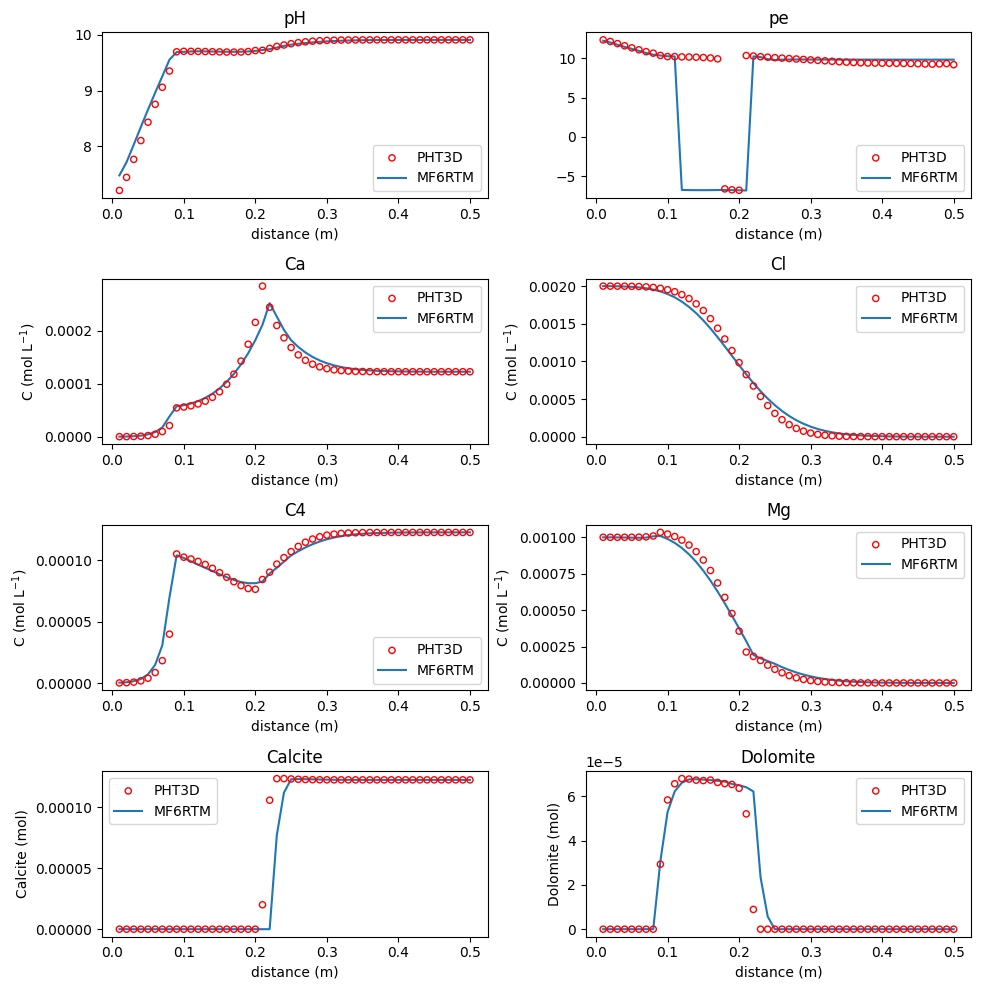

In [12]:
wd = os.path.join(f'{prefix}','pht3d')
dx = 0.01
simdf = pd.read_csv(os.path.join(wd, 'out.dat'), sep = '\t', skipinitialspace=True, index_col=[0])
simdf.drop(simdf.columns[len(simdf.columns)-1], axis=1, inplace=True)

simdf.loc[:, 'x'] = simdf['cell'] * dx 
simdf.drop(columns = 'H', inplace = True)

simapi = pd.read_csv(os.path.join(model.wd,'sout.csv'), sep = ',', skipinitialspace=True, index_col=[0])
simapi.loc[:, 'x'] = (simapi['cell'] + 1)*delr
simapi = simapi[simdf.columns]

simapi

fig, axs = plt.subplots(4,2, figsize = (10, 10))


for var, ax in zip(simapi.iloc[:,1:-1 ].columns, axs.flatten()):
    ax.scatter(simdf.x.unique(), simdf.loc[perlen, var], label = 'PHT3D', s=20, edgecolors='r', facecolors='none', zorder=10)
    ax.plot(simapi.x.unique(), simapi.loc[simapi.index.unique()[-1], var], label = 'MF6RTM')
    ax.set_xlabel('distance (m)')
    if var not in ['pH', 'pe'] and len(var) < 3:
        ax.set_ylabel('C (mol L$^{-1}$)')
    elif len(var) > 3:
        ax.set_ylabel(f'{var} (mol)')
    ax.set_title(f'{var}')
    ax.legend()
fig.tight_layout()
fig.savefig(os.path.join(f'{prefix}.png'))